# Praca domowa nr 4

Adrianna Grudzień\
22 kwietnia 2021 r. 

W ramach pracy domowej z przedmiotu Warsztaty badawcze zbadałam `wrażliwość sieci neuronowej` zbudowanej dla zbioru CIFAR-10. Dokonałam perturbacji w obrębie:

1. danych wejściowych
2. wszystkich wag modelu
3. wag w określonej warstwie


In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense

from keras.utils import np_utils

In [3]:
from keras.datasets import cifar10

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

num_classes = len(np.unique(y_train)) # liczba klas (10)
X_train = X_train.astype('float32')/255 # normalizujemy; dzielimy przez 255, bo jest to największa występująca wartość
X_test = X_test.astype('float32')/255
y_train = np_utils.to_categorical(y_train, num_classes) # one-hot enc.
y_test = np_utils.to_categorical(y_test, num_classes)

### Przykładowy obrazek

Klasy występujące w zbiorze to `['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']`

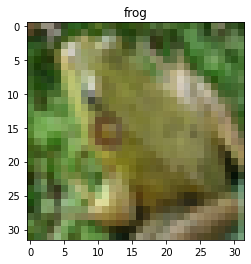

In [4]:
plt.imshow(X_test[163])
plt.title('frog')
plt.show()

### Funkcje pomocnicze

In [5]:
def miary_jakosci(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    return score

def wielokrotny_trening(model, X_train, y_train, X_test, y_test, n=3):
    wektor_acc = []
    wektor_loss = []
    for i in range(n):
        results = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
        score = miary_jakosci(model, X_test, y_test)
        wektor_loss.append(score[0])
        wektor_acc.append(score[1])
    print('Accuracy\n mean:', np.mean(wektor_acc), '\n std:', np.std(wektor_acc))
    print('Loss\n mean:', np.mean(wektor_loss), '\n std:', np.std(wektor_loss))

# Model

In [6]:
def buduj_model():
    model = Sequential()

    model.add(Convolution2D(48,(3, 3),activation='relu',input_shape=(32,32,3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.27))

    model.add(Convolution2D(192,(3, 3),activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.28))

    model.add(Flatten())
    model.add(Dense(512,activation = 'relu'))
    model.add(Dropout(0.4))

    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = buduj_model()

In [7]:
wielokrotny_trening(model, X_train, y_train, X_test, y_test, n=3)buduj_model

Accuracy
 mean: 0.7441333532333374 
 std: 0.007023940891734534
Loss
 mean: 0.7707138856252035 
 std: 0.010700586374148412


# Perturbacja danych wejściowych

W każdym obrazku wybieram średnio 10% wszystkich pikseli i losowo zmieniam ich wartość.

### Obrazek przed modyfikacją

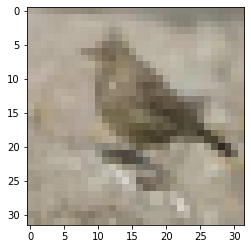

In [8]:
plt.imshow(X_train[120])

In [7]:
def zaszum(dataset):
    number =  dataset.shape[0]
    p = 0.9 # prawdopodobieństwo niewybrania piksela
    for i in range(number):
        im = dataset[i]
        wybrane_piksele = np.random.choice(a=[False, True], size=im.shape, p=[p, 1-p])
        nowa_macierz = np.random.random(im.shape)
        im[wybrane_piksele] = nowa_macierz[wybrane_piksele]

zaszum(X_train)
zaszum(X_test)

### Obrazek po modyfikacji

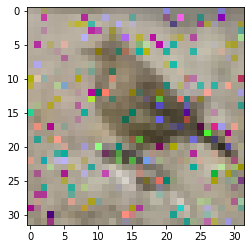

In [10]:
plt.imshow(X_train[120])

In [8]:
wielokrotny_trening(model,X_train, y_train, X_test, y_test, n=3)

Accuracy
 mean: 0.6791666746139526 
 std: 0.012047772491502396
Loss
 mean: 0.939781387646993 
 std: 0.013655611878869265


Dla przypomnienia - dla początkowego modelu otrzymaliśmy następujące wyniki:

```R
Accuracy
 mean: 0.7441333532333374 
 std: 0.007023940891734534
Loss
 mean: 0.7707138856252035 
 std: 0.010700586374148412
```
Jak widzimy, wyniki znacząco się pogorszyły. Średnie accuracy zmalało, a jego odchylenie standardowe zwiększyło się. Średnie loss oraz jego odchylenie standardowe zwiększyło się.

Wynika z tego, że zaszumienie obrazków jest niewskazane.

# Perturbacja wszystkich wag modelu

Modyfikujemy wszystkie wagi modelu. Dla uproszczenia do każdej wartości dodajemy 0.01.

In [19]:
#  Przygotowujemy zbiory od nowa
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
num_classes = len(np.unique(y_train)) # liczba klas (10)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [20]:
# funkcja tworząca model ze zmodyfikowanymi wagami we wszystkich warstwach
def zmiana_wag(): 
    #  Przygotowujemy zbiory od nowa
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    num_classes = len(np.unique(y_train)) # liczba klas (10)
    X_train = X_train.astype('float32')/255
    X_test = X_test.astype('float32')/255
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    # Przygotowujemy model od nowa
    model = buduj_model()
    # Trenujemy model
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    # Zmieniamy wagi
    wagi = np.array(model.get_weights())
    model.set_weights(wagi + 0.01)
    return model

def zmieniaj_wielokrotnie(n=3):
    wektor_acc = []
    wektor_loss = []
    for i in range(n):
        model = zmiana_wag()
        score = miary_jakosci(model, X_test, y_test)
        wektor_loss.append(score[0])
        wektor_acc.append(score[1])
    print('Accuracy\n mean:', np.mean(wektor_acc), '\n std:', np.std(wektor_acc))
    print('Loss\n mean:', np.mean(wektor_loss), '\n std:', np.std(wektor_loss))        

In [21]:
zmieniaj_wielokrotnie(3)

/home/ada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Accuracy
 mean: 0.23526667058467865 
 std: 0.025273087236045853
Loss
 mean: 21.108353932698567 
 std: 4.367065232855363


Dla przypomnienia - dla początkowego modelu otrzymaliśmy następujące wyniki:

```R
Accuracy
 mean: 0.7441333532333374 
 std: 0.007023940891734534
Loss
 mean: 0.7707138856252035 
 std: 0.010700586374148412
```
Jak widzimy, wyniki dramatycznie się pogorszyły. W celach badawczych można by poeksperymentować z modyfikacją pojedynczych wag wybieranych losowo z każdej warstwy, ale w tym przypadku zostaniemy przy zmiane wszystkich wag na raz.

Średnie accuracy zmalało ponad trzykrotnie, a jego odchylenie standardowe znacząco się zwiększyło (a chcemy, żeby było jak najmniejsze). Średnie loss rozpaczliwie wzrosło - z niecałego 1 do ponad 21, jego odchylenie standardowe również wzrosło. 

Wyniki są zatrważające - wagi lepiej zostawić samym sobie, ewentualnie nie zmieniać wszystkich na raz.

# Perturbacja wag w określonej warstwie

Modyfikujemy wagi w warstwie `Dense(512,activation = 'relu')` poprzez dodanie do każdej wartości 0.01.

In [23]:
# funkcja tworząca model ze zmodyfikowanymi wagami:
def zmiana_wag(): 
    #  Przygotowujemy zbiory od nowa
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    num_classes = len(np.unique(y_train)) # liczba klas (10)
    X_train = X_train.astype('float32')/255
    X_test = X_test.astype('float32')/255
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    # Przygotowujemy model od nowa
    model = buduj_model()
    # Trenujemy model
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    
    wagi = model.layers[7].get_weights()
    model.layers[7].set_weights([wagi[0]+0.01, wagi[1]+0.01])
    return model

def zmieniaj_wielokrotnie(n=3):
    wektor_acc = []
    wektor_loss = []
    for i in range(n):
        model = zmiana_wag()
        score = miary_jakosci(model, X_test, y_test)
        wektor_loss.append(score[0])
        wektor_acc.append(score[1])
    print('Accuracy\n mean:', np.mean(wektor_acc), '\n std:', np.std(wektor_acc))
    print('Loss\n mean:', np.mean(wektor_loss), '\n std:', np.std(wektor_loss))        

In [ ]:
# żeby nie wyświetlały się błędy...
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

In [24]:
zmieniaj_wielokrotnie(3)

Accuracy
 mean: 0.7125333348910013 
 std: 0.01065623014715914
Loss
 mean: 0.9471496939659119 
 std: 0.015754252560089655


Dla przypomnienia - dla `pierwotnego modelu` otrzymaliśmy następujące wyniki:

```R
Accuracy
 mean: 0.7441333532333374 
 std: 0.007023940891734534
Loss
 mean: 0.7707138856252035 
 std: 0.010700586374148412
```
oraz dla zmodyfikowanych wag `we wszystkich warstwach`:

```R
Accuracy
 mean: 0.23526667058467865 
 std: 0.025273087236045853
Loss
 mean: 21.108353932698567 
 std: 4.367065232855363
```
to jeszcze wypiszemy ładnie dla wag zmienionych `w jednej warstwie`:
```R
Accuracy
 mean: 0.7125333348910013 
 std: 0.01065623014715914
Loss
 mean: 0.9471496939659119 
 std: 0.015754252560089655
```

Jak widzimy, wyniki, w porówaniu do pierwotnego modelu, nieznacznie się zmieniły. Średnie accuracy zmalało o 0.03, a jego odchylenie standardowe wzrosło (to źle). Średnie loss wzrosło z 0.77 do 0.95, a jego odchylenie standardowe zwiększyło się o 0.005.

Intuicyjnie, perturbacje wag z tylko jednej warstwy powinny powodować mniejsze pogorszenie modelu niż perturbacje wag wszystkich warstw. Czy rzeczywiście tak jest? Tak, różnica wyników jest kolosalnie przytłaczająca.

### Wnioski

Wnioski są takie, że nawet małe zmiany wagowe i danych wejściowych mają wpływ na końcowy wynik modelu i jego miary jakości. Dobrze jest mieć obrazki dobrej jakości (bez żadnych szumów) oraz dobrze jest nie zmieniać wag ręcznie.

# Niepewność

Istnieją dwa główne typy niepewności w uczeniu głębokim: niepewność opisująca, czego model nie wie, ponieważ dane treningowe nie były odpowiednie oraz niepewność wynikająca z ograniczonych danych i wiedzy.

Z niepewnością można sobie poradzić przy pomocy prawdopodobieństwa i statystyki. Przykładowo, jeśli chodzi o błąd modelu, prawdopodobieństwo pomaga zrozumieć i określić ilościowo oczekiwaną zdolność i wariancję działania modelu predykcyjnych w zastosowaniu do nowych danych.